# Constraining Cosmological Parameters by Using Type Ia Supernova Data

## 1. Data Preparation

In this notebook, we will use type Ia supernova data from https://sne.space/.

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import integrate, optimize

%matplotlib inline  

# set basic figure parameters
import matplotlib as mpl
mpl_param = {'figure.figsize'   : [8.0, 6.0],
             'savefig.dpi'      : 100,
             'axes.titlesize'   : 'xx-large',
             'axes.labelsize'   : 'xx-large',
             'text.usetex'      : False,
             'font.family'      : 'serif'}
mpl.rcParams.update(mpl_param)


# =============================================================================
# Data cleaning
# =============================================================================

# read json data
data = pd.read_json('supernova.json')

# define list of strings to be removed
bad_string = '(host|spectroscopic|heliocentric|cmb|photometric|cluster|,)'

# define list of columns to be removed
bad_column = ['z', 'dL (Mpc)', 'mmax', 'Mmax']

# replace z and dL value with valid float numbers
# nan means Not A Number
for i in bad_column:
    data[i] = data[i].str.replace(bad_string, '')
    data[i].loc[data[i] == ''] = np.nan
    data[i] = data[i].astype(float)

# sort data by redshift value
data = data.sort_values(by=['z'])

# redshift cut until z~2
data = data.loc[data['z'] <= 2]


data.head()

/home/irhamta/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,,Airmass,Aliases,Alt. (°),Azi. (°),Data,Dec.,Disc. Date,Discoverer,E(B-V),...,Radio,References,Spec.,Type,Vsky,X-ray,dL (Mpc),mmax,v☉,z
244,,1.180,AAVSO 1221+15,57.897,187.928,,+15:03:17.1 15.05475°,1984/01/04 MJD: 45703.5,"Kimeridze, Rosino,Kimeridze,",0.0284,...,0,1986Afz....25..279K1989A&A...220...83B2012A&A....,,"Ia-HV Ia,I",4.679,,17.00000,12.10,-256 host,-0.000920
2273,,,,-15.862,74.072,,-01:07:08.9 -1.11914°,2006/10/02 MJD: 54010.5,,0.1783,...,,2014arXiv1401.3317S2012ApJ...755...61S2008AJ.....,,Ia,,,1061.80000,20.87,56200,0.000000
11076,,,"LMCSNR J053402-695503, MCSNR J0534-6955",-49.212,210.072,,-69:55:03 -69.91750°,,,0.8733,...,,2016A&A...585A.162M2016A&A...594A..13P2011ApJ....,,Ia,,,0.05001,NaN,3.388,0.000011
11075,,,"LMCSNR J051935-690209, MCSNR J0519-6902",-50.415,211.568,,-69:02:09 -69.03583°,,,0.7637,...,,2016A&A...585A.162M2016A&A...594A..13P2011ApJ....,,Ia,,,0.05001,NaN,3.388,0.000011
11078,,,"LMCSNR J053418-703326, MCSNR J0534-7033",-49.242,209.093,,-70:33:26 -70.55722°,,,0.2237,...,,2016A&A...585A.162M2016A&A...594A..13P2011ApJ....,,Ia,,,0.05001,NaN,3.388,0.000011


Text(0,0.5,'Luminosity Distance (MPC)')

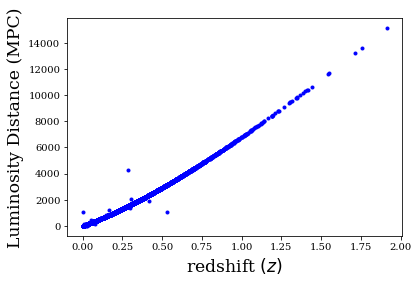

In [2]:
# plot redshift vs distance modulus
plt.plot(data['z'], data['dL (Mpc)'], 'b.')
plt.xlabel('redshift $(z)$')
plt.ylabel('Luminosity Distance (MPC)')

## 2. Luminosity Distance

Luminosity distance ($d_L$) for various cosmological models are usually formulated as

\begin{equation}
    d_L(z) = \frac{c (1+z_2)}{H_0} 
        \times \int_{z_1}^{z_2}{
            \frac{dz'}{\sqrt{
                \Omega_{\rm m}(1+z')^3 + \Omega_{\rm r}(1+z')^4 + \Omega_{\rm de}(1+z')^{3(1+w_{\rm de})
               }}}}
\end{equation}

Here, we consider a spatially flat universe ($\Omega_{\rm m} + \Omega_\Lambda = 1$, $w_{\rm de} = -1$). Therefore, that we can write it as following codes.

In [3]:
# define some basic constants
c = 3 * 1e5 # km/s
H0 = 67.7 #km / (Mpc s)
Omega_m = 0.307
Omega_r = 0 * 1e-5 # too small
Omega_lambda = 1 - Omega_m

# make luminosity distance function
def lum_dist (z, Omega_m, Omega_lambda, H0):

    Omega_r = 0 * 1e-5 # too small

    # integration part
    # integration is calculated from redshift=0 to redshift=z
    fn = lambda z: (Omega_r*(1+z)**4. \
                    + Omega_m*(1+z)**3 \
                    + Omega_lambda\
                   )**-0.5

    # return array values
    return c*(1+z)/H0 * np.asarray([integrate.quad(fn, 0, _z)[0] for _z in z])

For a quick insight, we can do the least-square fitting to obtain cosmological parameters.

In [4]:
# remove NaN values
data_good = data[['z', 'dL (Mpc)']].dropna()
data_good = data_good.sample(n=500)


# guess initial parameters
# Omega_m, Omega_lambda, H0, respectively
initial_param = np.array([0.3, 0.7, 70])

# least-square fitting
opt_param, cov = optimize.curve_fit(lum_dist, 
                                    data_good['z'].values, 
                                    data_good['dL (Mpc)'].values, 
                                    p0=initial_param)
err_param = np.sqrt(np.diag(cov))

/home/irhamta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/irhamta/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


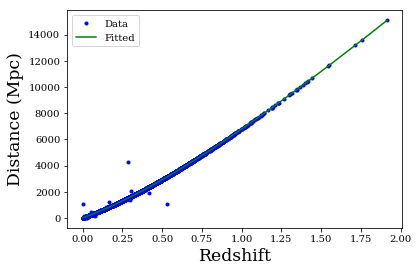

Least-Square Fitting Final parameter:
Omega_m = 0.28 (8746.867976)
Omega_lambda = 0.62 (19275.338208)
H0 = 71.56 (1120620.216428)


In [5]:
# =============================================================================
# Plot the result
# =============================================================================

plt.figure()
plt.plot(data['z'], data['dL (Mpc)'], 'b.', label='Data')
plt.plot(data['z'], lum_dist(data['z'], *opt_param), 
         'g-', label='Fitted')
plt.ylabel('Distance (Mpc)')
plt.xlabel('Redshift')
plt.legend()
plt.show()


print ('======================================')
print ('Least-Square Fitting Final parameter:')
print ('Omega_m = %.2f (%f)' %(opt_param[0], err_param[0]))
print ('Omega_lambda = %.2f (%f)' %(opt_param[1], err_param[1]))
print ('H0 = %.2f (%f)' %(opt_param[2], err_param[2]))
print ('======================================')

## 3. Maximum Likelihood Fitting

We will use maximization of the likelihood function to constrain and compare the models. First, we calculate $d_{L}^{\rm obs}$ and $d_{L}^{\rm th}$. Then, the join likelihood function for all parameters, based on a flat Bayesian prior, is

\begin{equation}
    \mathcal{L} = \prod_{i} \exp{\bigg[-\frac{\chi^2}{2} \bigg]}
\end{equation}

where for each measurement

\begin{equation}
    \chi^2_i = \frac{(d_{L_i}^{\rm obs} - d_{L_i}^{\rm th})^2}{\sigma^2_{d_{L_i}}}
\end{equation}

In python, those equations can be written as below.

In [6]:
# =============================================================================
# Maximum likelihood fitting
# =============================================================================


# define likelihood function as in Equation 11 in Leaf et al. (2018)
def lnlike(theta, X, y, yerr):

    Omega_m, Omega_lambda, H0 = theta
    model = lum_dist(X, Omega_m, Omega_lambda, H0)

    # chi-square
    chi2 = ((y-model)**2)/yerr**2

    return np.sum( np.exp(-chi2/2) )

X = data_good['z'].values
y = data_good['dL (Mpc)'].values
yerr = 0.05 # assuming there is uniform error about 5%

In [7]:
from scipy import optimize

# optimize module minimizes functions whereas we would like to maximize the likelihood
# that's why I put the minus(-) sign
nll = lambda *args: -lnlike(*args)
#result = optimize.minimize(nll, initial_param, args=(X, y, yerr))
#m_ml, b_ml, h0_ml, wde_ml = result["x"]

print ('======================================')
#print ('Maximum Likelihood Result')
#print ('Omega_m = %.2f (%.2f)' %(m_ml, 0))
#print ('Omega_lambda = %.2f (%.2f)' %(b_ml, 0))
#print ('H0 = %.2f (%.2f)' %(h0_ml, 0))
#print ('wde = %.2f (%.2f)' %(wde_ml, 0))
print ('======================================\n')

## 4. Markov Chain Monte Carlo Fitting

In order to improve our fitting accuracy, we will use emcee, which is pure-Python implementation of Goodman & Weare's Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler. These pages (http://emcee.readthedocs.io/en/stable/) will show you how to use it. We would like to marginalize over some "nuisance parameters" and find an estimate of the posterior probability function (the distribution of parameters that is consistent with dataset) for others. 

We will define uniform (so-called "uninformative") priors on initial parameters ($\Omega_{\rm m}$, $\Omega_{\Lambda}$, and $H_0$). Then, combining this with the definition of lnlike from above, the full log-probability function can be calculated.

In [8]:
# =============================================================================
# MCMC fitting
# see http://dfm.io/emcee/current/user/line/ for the detail
# =============================================================================

# define prior
def lnprior(theta):
    Omega_m, Omega_lambda, H0 = theta
    
    if 0.95 <= Omega_m + Omega_lambda <= 1.05 \
    and 0 < Omega_m < 1.5 \
    and 0 < Omega_lambda < 1.5 \
    and 60 < H0 < 80:
        return 0
    return -np.inf

# define the full probability
def lnprob(theta, X, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, X, y, yerr)

In [9]:
ndim, nwalkers = 3, 1000

pos = [initial_param + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]


import emcee
import sys

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(X, y, yerr), threads=3)

nsteps = 500
width = 30

print ('running MCMC.....')
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

running MCMC.....
[##############################]


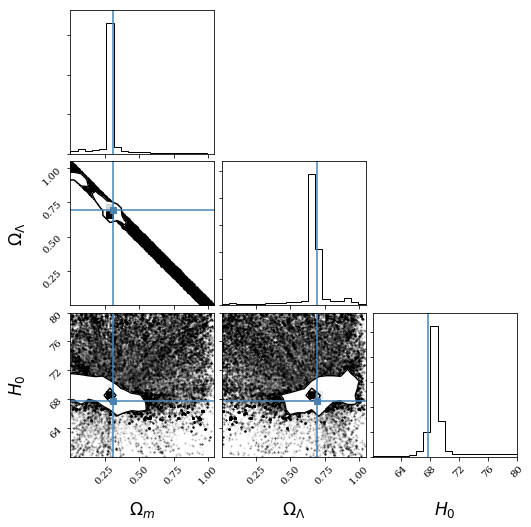

In [10]:
import corner
fig = corner.corner(samples, labels=["$\Omega_m$", "$\Omega_\Lambda$", "$H_0$"],
                      truths=[Omega_m, Omega_lambda, H0])


plt.savefig('result/supernova.png')
plt.show()




In [11]:
m_mcmc, b_mcmc, h0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                   zip(*np.percentile(samples, [16, 50, 84],
                                                      axis=0)))

print ('============================================================================')
print ('MCMC Result')
print ('Omega_m = ', m_mcmc)
print ('Omega_lambda = ', b_mcmc)
print ('H0 = ', h0_mcmc)
print ('============================================================================')


output_data = pd.DataFrame({'omega_m': samples[:, 0], 
                            'omega_l': samples[:, 1],
                            'h0'     : samples[:, 2]})
output_data.to_csv('result/output_supernova.csv', index=False)

MCMC Result
Omega_m =  (0.30166214003237946, 0.010601759941790578, 0.006677495582416815)
Omega_lambda =  (0.6749308524546039, 0.021825491761950255, 0.012705856920557035)
H0 =  (68.6734042618426, 0.6701585025228525, 0.6150923190433701)
